# Imports

In [9]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Functions

In [10]:
def json_to_df(file_path):
    # Load the JSON file
    with open(file_path, 'r') as file:
        data = json.load(file)

    # Extracting relevant data from each record
    extracted_data = []
    for record in data:
        client_name = record['sender']['name']
        correlation_id = record['correlationId']
        training_info = json.loads(record['data'])
        extracted_data.append({
            'client': client_name,
            'correlationId': correlation_id,
            'training_loss': training_info['training_loss'],
            'training_accuracy': training_info['training_accuracy'],
            'test_loss': training_info['test_loss'],
            'test_accuracy': training_info['test_accuracy']
        })

    # Creating a DataFrame from the extracted data
    df = pd.DataFrame(extracted_data)

    # Creating a mapping of correlationId to readable round numbers
    unique_correlation_ids = df['correlationId'].unique()
    round_mapping = {correlation_id: f'Round {i+1}' for i, correlation_id in enumerate(unique_correlation_ids)}

    # Applying the mapping to the DataFrame
    df['Round'] = df['correlationId'].map(round_mapping)

    # Initializing the aggregated data dictionary with lists for each metric
    aggregated_data = {
        'Round': [],
        'training_accuracy': [],
        'training_loss': [],
        'test_accuracy': [],
        'test_loss': []
    }

    # Aggregating data for each round
    for round_label in df['Round'].unique():
        round_data = df[df['Round'] == round_label]
        aggregated_data['Round'].extend([round_label] * len(round_data))
        aggregated_data['training_accuracy'].extend(round_data['training_accuracy'])
        aggregated_data['training_loss'].extend(round_data['training_loss'])
        aggregated_data['test_accuracy'].extend(round_data['test_accuracy'])
        aggregated_data['test_loss'].extend(round_data['test_loss'])

    # Converting aggregated data into a DataFrame for plotting
    df_aggregated = pd.DataFrame(aggregated_data)

    # Create copy of df
    df = df_aggregated.copy()

    # Group by Round and calculate mean for 
    df = df.groupby('Round').mean()

    # Sort by index
    df.index = df.index.astype(str)
    numeric_index = df.index.str.extract('(\d+)')[0].astype(int)
    df = df.iloc[numeric_index.argsort()]
    
    return df

# Solution

In [19]:
###############################################################################################
#root = "Backdoor/40_clients_40_rounds"
#files = ['40_client_5_1.json','40_client_5_2.json','40_client_5_3.json']
#merged_files = []
#file_labels = ["run_1","run_2","run_3"]

#root = "Backdoor/40_clients_10_rounds"
#files = ['40_client_5_1.json','40_client_5_2.json','40_client_5_3.json']
#erged_files = []
#ile_labels = ["run_1","run_2","run_3"]

root = "Backdoor/10_clients_20_rounds"
files = ['10_client_10_1.json']
merged_files = []
file_labels = ["run_1"]



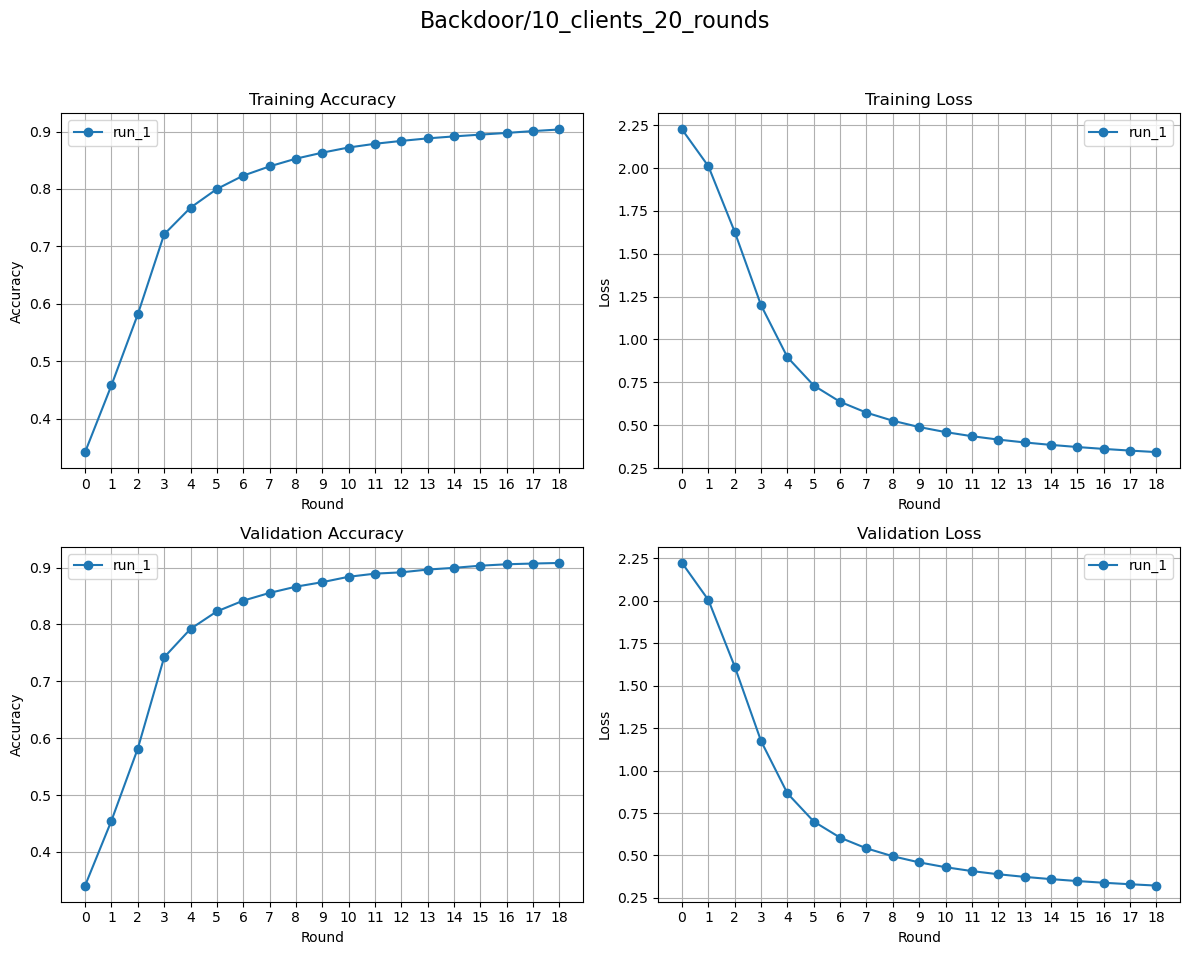

In [20]:
file_paths = [root+"/"+file for file in files]


# Load raw json data from files
dfs = []
for path in file_paths:
    dfs.append(json_to_df(path))  # Each json becomes a df with 4 columns
    

# If any merged files are to be printed (handled seperatly because they are already dfs but in .json format)
if merged_files != None:
    merged_file_paths = [root+"/"+file for file in merged_files]
    for filename in merged_file_paths:
        dfs.append(pd.read_json(filename, orient='index'))
    

# Create 2x2 plot grid
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Iterate over each dataframe and plot on the same axes
for df, label in zip(dfs, file_labels):
    axs[0, 0].plot(df.index, df['training_accuracy'], marker='o', label=label)
    axs[0, 1].plot(df.index, df['training_loss'], marker='o', label=label)
    axs[1, 0].plot(df.index, df['test_accuracy'], marker='o', label=label)
    axs[1, 1].plot(df.index, df['test_loss'], marker='o', label=label)
    
    ticks = axs[0, 0].get_xticks()
    axs[0, 0].set_xticks(ticks)
    axs[0, 0].set_xticklabels(ticks)
    
    ticks = axs[0, 1].get_xticks()
    axs[0, 1].set_xticks(ticks)
    axs[0, 1].set_xticklabels(ticks)
    
    ticks = axs[1, 0].get_xticks()
    axs[1, 0].set_xticks(ticks)
    axs[1, 0].set_xticklabels(ticks)
    
    ticks = axs[1, 1].get_xticks()
    axs[1, 1].set_xticks(ticks)
    axs[1, 1].set_xticklabels(ticks)

    axs[0, 0].set_xlabel('Round')
    axs[0, 1].set_xlabel('Round')
    axs[1, 0].set_xlabel('Round')
    axs[1, 1].set_xlabel('Round')
    
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 1].set_ylabel('Loss')
    axs[1, 0].set_ylabel('Accuracy')
    axs[1, 1].set_ylabel('Loss')
    
    
    
axs[0, 0].grid()
axs[0, 1].grid()
axs[1, 0].grid()
axs[1, 1].grid()

axs[0, 0].set_title('Training Accuracy')
axs[0, 1].set_title('Training Loss')
axs[1, 0].set_title('Validation Accuracy')
axs[1, 1].set_title('Validation Loss')

# Add legends
for ax in axs.flat:
    ax.legend()

# Title
plt.suptitle(root, fontsize=16)


# Adjust layout to accommodate the main title
plt.tight_layout(rect=[0, 0.03, 1, 0.95])


# Savefig
plt.savefig(root+"/comparison.png")
